# SIR metapopulation model for humans (density dependent transmission)
This is the Python version of program 7.2 from page 242 of "Modeling Infectious Disease in humans and animals" by Keeling & Rohani.
This is based on code written by Ilias Soumpasis.

Metapopulations are one of the simplest spatial models, but are also one of the most applicable to modeling many human diseases. The metapopulation concept is to subdivide the entire population into distinct “subpopulations”, each of which has independent epidemiological dynamics, together with limited interaction between the subpopulations.
For human populations, permanent relocation from one population to another is sufficiently rare that it may be ignored as an epidemiologically significant force. Instead, it is more natural to think about commuters spreading the disease. Commuters live in one subpopulation but travel occasionally to another subpopulation. We therefore label Xij, Yij , and Nij as the number of susceptibles, infecteds, and total hosts currently in population i that live in population j. When there are multiple communities within the metapopulation, and when the populations are of different sizes or the strengths of interaction differ, it is more informative to return to first principles to calculate the dynamics.

In [1]:
import scipy.integrate as spi
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties as fmp

In [2]:
#parameters (time units are days)

n=5 #number of subpopulations
beta=1.0*np.ones(n); #transmission rate between subpopulations
gamma=0.3*np.ones(n); #recovery rate

#initial distribution of population amongst subpopulations
N0=np.zeros(n*n); 
X0=np.zeros(n*n);
for i in np.arange(0,n*n,n+1):
	N0[i]=1000.0
	X0[i]=800.0

Y0=np.zeros(n*n); 
Y0[0]=1.0; #initially one infected in one of the subpopulations

ND=MaxTime=60. #number of days of simulation
TS=1.0 #time step (one day)

l=np.zeros((n,n)); #rate at which individuals leave their home subpopulation
r=np.zeros((n,n)) #rate at which individuals return to their home subpopulation
for i in range(n):
	for j in range(n):
		if abs(i-j)==1: 
			l[i][j]=0.1
r=2*np.ones((n,n));
r=r-np.diag(np.diag(r));

INPUT0=np.hstack((X0,Y0,N0))
INPUT = np.zeros((3*n*n))
for i in range(n*n):
	INPUT[3*i]=INPUT0[i]
	INPUT[1+3*i]=INPUT0[n*n+i]
	INPUT[2+3*i]=INPUT0[2*n*n+i]

In [3]:
def diff_eqs(INP,t):  
	'''The main set of equations'''
	Y=np.zeros((3*n*n))
	V = INP   
	sumY=np.zeros(n)
	sumN=np.zeros(n)
	
	## Calculate number currently in Subpopulation i
	for i in range(n):
		sumY[i]=0.0;sumN[i]=0.0
		for j in range(n):
			k=3*(j+i*n);
			sumN[i]+=V[2+k];
			sumY[i]+=V[1+k];	
			
	## Set all rates to zeros
	for i in range(n):
		for j in range(n):
			k=3*(j+i*n);
			Y[k]=0; Y[1+k]=0; Y[2+k]=0
	
	for i in range(n):
		for j in range(n):		
			## Calculate the rates
			k = 3 * (j+i*n) 
			K = 3 * (i+j*n)
			h = 3 * (i+i*n)
			H = 3 * (j+j*n)
			
			Y[k] -= (beta[i]*V[k]*(sumY[i]/sumN[i]))
			Y[k+1] += (beta[i]*V[k]*(sumY[i]/sumN[i]))
			Y[k+1] -= (gamma[i]*V[k+1])
			
			## Movement
			Y[h] += r[j][i]*V[K]
			Y[h] -= l[j][i]*V[h]
			
			Y[h+1] += r[j][i]*V[K+1]
			Y[h+1] -= l[j][i]*V[h+1]
			
			Y[h+2] += r[j][i]*V[K+2]
			Y[h+2] -= l[j][i]*V[h+2]
			
			Y[k] += l[i][j]*V[H]
			Y[k] -= r[i][j]*V[k]
			
			Y[1+k] += l[i][j]*V[1+H]
			Y[1+k] -= r[i][j]*V[1+k]
			
			Y[2+k] += l[i][j]*V[2+H]
			Y[2+k] -= r[i][j]*V[2+k]
	return Y   # For odeint

In [4]:
t_start = 0.0; t_end = ND; t_inc = TS
t_range = np.arange(t_start, t_end+t_inc, t_inc)
t_course = spi.odeint(diff_eqs,INPUT,t_range)
tc = t_course

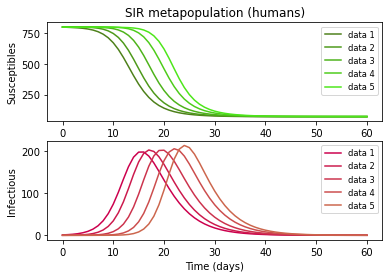

In [14]:
import pylab as pl
### Plotting
totalS=np.zeros((len(tc),5))
totalI=np.zeros((len(tc),5))

for i in range(n):
	for j in range(n):
		k=3*(j+i*n);
		totalS[:,i]+=tc[:,k]
		totalI[:,i]+=tc[:,k+1]


#print len(totalS)
fig = plt.figure()
plt.title('SIR metapopulation (humans)')
plt.axis('off')
fig.add_subplot(211)
#pl.subplot(211)
for i in range(5):
	plt.plot(t_range,totalS[:,i], label=('data %s' %(i+1)), color=(0.3,i/10.+0.5,0.1))
plt.xlabel('Time')
plt.ylabel('Susceptibles')
plt.legend(loc=1,prop = fmp(size='smaller'))
fig.add_subplot(212)
for i in range(5):
	plt.plot(t_range,totalI[:,i], label=('data %s' %(i+1)), color=(0.8,i/10.+0.,0.3))
plt.xlabel('Time (days)')
plt.ylabel('Infectious')
plt.legend(loc=1,prop = fmp(size='smaller'))

plt.show()
fig.savefig('metapopulation_humans.pdf')